In [9]:
import pandas as pd
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.ion()
from sklearn import svm
import os
from PIL import Image
from sklearn.model_selection import cross_val_score
from scipy import ndimage
from scipy import misc
from skimage.feature import local_binary_pattern as lbp

import warnings
warnings.filterwarnings("ignore")

On charge les deux listes des nomns des images sur lequelle porte notre recherche

In [10]:
Dir = u'C:\\Users\\hakim\\PycharmProjects\\TER'
sick = Dir+'\\PatchI9'+'\\Infarcted'
healthy = Dir+'\\PatchI9'+'\\Healthy'
h = os.listdir(healthy)
s = os.listdir(sick)
im= misc.imread(h[1])

On regarde quelques images des tissus sains et des tissus infectés.

<IPython.core.display.Javascript object>


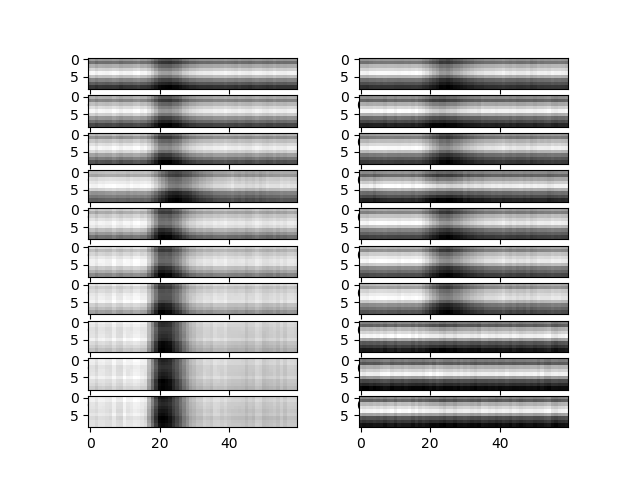

In [11]:
fig, L = plt.subplots(10, 2)
for i in range(L.shape[0]):   
        L[i,0].imshow(misc.imread(h[i]),plt.cm.gray)
        L[i,1].imshow(misc.imread(s[i]),plt.cm.gray)
fig.show()


On affiches l'histogramme des images precedantes

<IPython.core.display.Javascript object>


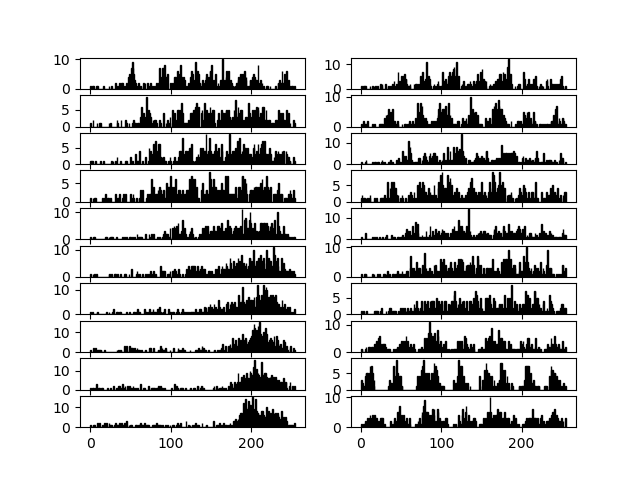

In [12]:
fig, L = plt.subplots(10, 2)
for i in range(L.shape[0]):   
        L[i,0].hist(misc.imread(h[i]).ravel(), bins=256,  fc='k', ec='k')
        L[i,1].hist(misc.imread(s[i]).ravel(), bins=256,  fc='k', ec='k')
fig.show()

Om affiches l'histograme de toutes les images en separant les tissues infeté et sains

In [33]:
col=range(0,256)
df0 = pd.DataFrame( columns=col)
df1 = pd.DataFrame( columns=col)

for image in h:
    im = misc.imread(image)
    bin_counts, bin_edges = np.histogram(im, bins = 256)
    df2 = pd.DataFrame( [bin_counts.tolist()] , columns=col)
    df0 = df0.append(df2)
for image in s:
    im = misc.imread(image)
    bin_counts, bin_edges = np.histogram(im, bins = 256)
    df2 = pd.DataFrame( [bin_counts.tolist()] , columns=col)
    df1 = df1.append(df2)

In [ ]:
h1 = [0]*256
s1 = [0]*256
for i in range(0,256):
    h1[i] = df0[i].values.sum()/len(h1)
    s1[i] = df1[i].values.sum()/len(s1)
print(len(h))

<IPython.core.display.Javascript object>


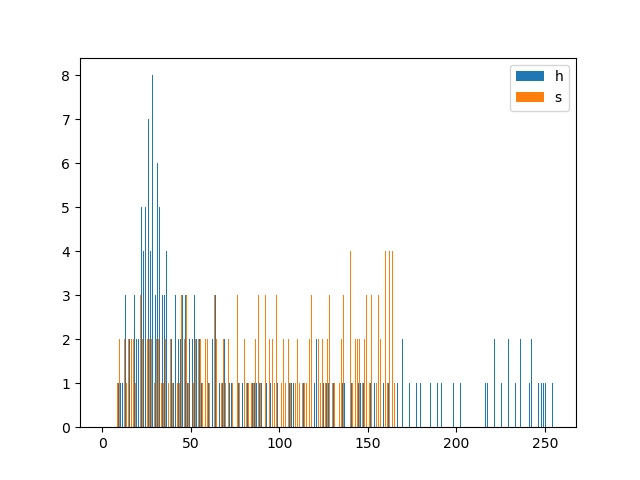

In [64]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.hist([h1, s1], bin_edges, label=['h', 's'])
ax.legend(loc='upper right')
plt.show()

On choisie d'appliquer 3 diferents filtres moyens sur les images, les tailles des filtres moyens sont repectivement : (1,1) (pas de lissage préliminaire), (3,3) et (5,5) , puis un LBP de voisinage (8,1) uniforme a chaque image, puis calculer l'histograme des ces nouvelle mages en intergralité puis en les decoupant en 2,4,6 et 12 imagettes, ce qui nous laisse un verteur descriptifs de chaque image de taille 3*25*59, puis réduie la dimentionalité, on applique la methode d'ACP avant de passer nos vercteur resultant au SVM avec un kernel polynomial de 3 degréé.

In [ ]:
col=range(0,59*25*3)
df0 = pd.DataFrame( columns=col)


h1 = []
s1 = []
print('healthy')
for nb_image in range(len(h)):
    h1 = []
    result=[]
    im = h[nb_image]
    im = misc.imread(im)
    result.append(ndimage.median_filter(im, size=(1,1)))
    result.append(ndimage.median_filter(im, size=(3,3)))
    result.append(ndimage.median_filter(im, size=(5,5)))
    result[0] = lbp(result[0], 8, 1, method='nri_uniform')
    result[1] = lbp(result[1], 8, 1, method='nri_uniform')
    result[2] = lbp(result[2], 8, 1, method='nri_uniform')
    for res in result:
        for i in [1,2,4,6,12]:
            for j in range(i):
                bin_counts, _= np.histogram(res[:,int(j*(60/i)):int((j+1)*(60/i)-1)], bins = 59)
                h1 +=bin_counts.tolist()
    df2 = pd.DataFrame( [h1] , columns=col)
    df0 = df0.append(df2)

healthy


In [ ]:
df1 = pd.DataFrame( columns=col)
s1=[]
print('sick')
for nb_image in range(len(s)):
    s1 = []
    result=[]
    im = s[nb_image]
    im = misc.imread(im)
    result.append(ndimage.median_filter(im, size=(1,1)))
    result.append(ndimage.median_filter(im, size=(3,3)))
    result.append(ndimage.median_filter(im, size=(5,5)))
    result[0] = lbp(result[0], 8, 1, method='nri_uniform')
    result[1] = lbp(result[1], 8, 1, method='nri_uniform')
    result[2] = lbp(result[2], 8, 1, method='nri_uniform')
    for res in result:
        for i in [1,2,4,6,12]:
            for j in range(i):
                bin_counts, _= np.histogram(res[:,int(j*(60/i)):int((j+1)*(60/i)-1)], bins = 59)
                s1 += bin_counts.tolist()
    df2 = pd.DataFrame( [s1] , columns=col)
    df1 = df1.append(df2)
    if nb_image in np.arange(0,len(s),100):
        print(nb_image/100)

In [9]:
df0.to_csv('healthy.csv')

In [15]:
df1.to_csv('sick.csv')

In [5]:
from sklearn.decomposition import PCA

In [17]:
x = df0.append(df1)

In [18]:
pca1 = PCA()

In [20]:
pca1.fit(x.values)
var= pca1.explained_variance_ratio_
var1=np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)
print(var)
print(var1)
plt.plot(var1)
"""
pca = PCA(n_components=30)
pca.fit(X)
X1=pca.fit_transform(X)

print X1
"""

[2.16299659e-01 8.46104708e-02 4.62235811e-02 ... 4.04597969e-34
 1.27828358e-34 3.77308657e-35]
[21.63 30.09 34.71 ... 97.27 97.27 97.27]


'\npca = PCA(n_components=30)\npca.fit(X)\nX1=pca.fit_transform(X)\n\nprint X1\n'

<IPython.core.display.Javascript object>


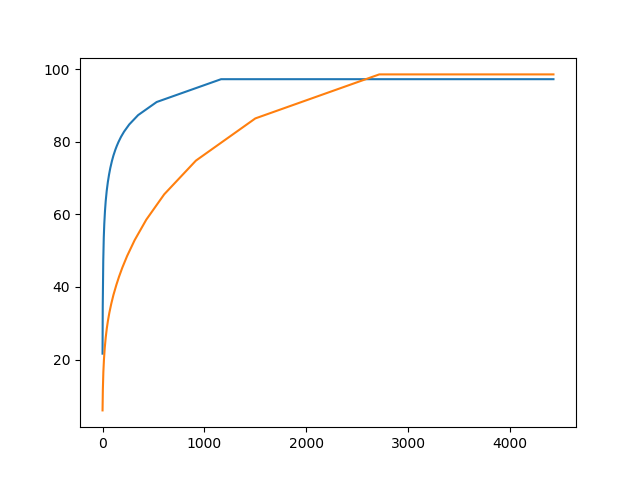

In [25]:
plt.plot(var1)

In [33]:
var1[4000]

97.27000000000275

In [3]:
x1 = pd.read_csv('healthy.csv')
x2 = pd.read_csv('sick.csv')
x = x1.append(x2)

In [34]:
from sklearn.preprocessing import scale
pca2 = PCA()
x_scaled = scale(x.values)
pca2.fit(x_scaled )
var= pca2.explained_variance_ratio_
var1=np.cumsum(np.round(pca2.explained_variance_ratio_, decimals=4)*100)
print(var)
print(var1)

[5.99203369e-02 2.70583545e-02 1.69439455e-02 ... 1.92748850e-34
 1.87998496e-34 2.13402136e-35]
[ 5.99  8.7  10.39 ... 98.59 98.59 98.59]


In [35]:
plt.plot(var1)


In [6]:
print(x.head())
pca = PCA(n_components=745)
pca.fit(x.values)
X1=pca.fit_transform(x.values)

   Unnamed: 0   0   1  2  3  4   5  6  7  8  ...   4415  4416  4417  4418  \
0           0  25  35  0  0  0  29  0  0  0  ...      0     1     0     0   
1           0  27  32  0  0  0  24  0  0  0  ...      0     1     0     0   
2           0  27  31  0  0  0  23  0  0  0  ...      0     1     0     0   
3           0  24  38  0  0  0  16  0  0  0  ...      0     0     0     0   
4           0  26  29  0  0  0  19  0  1  0  ...      0     0     0     0   

   4419  4420  4421  4422  4423  4424  
0     0     0     0     0     0     2  
1     0     0     0     0     0     4  
2     0     0     0     0     0     4  
3     0     0     0     0     0     2  
4     0     0     0     0     0     3  

[5 rows x 4426 columns]


In [7]:
label_h = [0]*len(h)
label_s = [1]*len(s)
label = np.array(label_h+label_s)
from sklearn.svm import SVC
clf = SVC(kernel =  'poly', degree = 3)
print('___ starting cross validation ___')
scores = cross_val_score(clf,X1, label, cv=5)
print('__ Done __')

___ starting cross validation ___
__ Done __


In [8]:
scores

array([0.78064224, 0.69147252, 0.66704366, 0.70142502, 0.74479638])

In [14]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.08)
